In [1]:
%matplotlib inline
from ecell4 import *

In [18]:
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
import numpy
rng = core.GSLRandomNumberGenerator()

In [19]:
def create_model(k, D, radius=0.005):
    with species_attributes():
        A | B | {'D': str(D), 'radius': str(radius), 'location': 'X'}
    with reaction_rules():
        A + B > B | k # uma^2/s
    return get_model()

In [20]:
def singlerun(k, D, voxel_radius, L, N,run):
    radius = voxel_radius
    NB = N
    rng.seed(run)
    m = create_model(k, D, radius)
    w = spatiocyte.SpatiocyteWorld(ones() * L, voxel_radius,rng)
    w.bind_to(m)
    w.add_structure(Species('X'), PlanarSurface(unitx() * L / 2, unity() * L, unitz() * L))
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), NB)
    sim = spatiocyte.SpatiocyteSimulator(w)
    obs = NumberObserver(['A'])
    while len(obs.data()) == 0 or obs.data()[-1][1] > N * 0.2:
        sim.run(0.1, obs)
    return obs

In [21]:
def expfunc(k, N):
    def func(x):
        return N * numpy.exp(-k * x)
    return func

In [28]:
D = 0.01
voxel_radius = 0.005#*2
L = 3.0
N = 240

In [55]:
ks = []
observers = []
params = []

for k in (1000.0, 316.0, 100.0, 31.6, 10.0, 3.16, 1.0, 0.316, 0.1, 0.0316, 0.01):
    alpha = (D + D) / (0.28986264423934294 * k)

    for i in range(1):
        obs = singlerun(k, D, voxel_radius, L, N,i)
        data = numpy.array(obs.data()).T
        p, covar = curve_fit(lambda x, *args: expfunc(args[0], N)(x), data[0], data[1], p0=[k])
        ks.append(k)
        observers.append(obs)
        params.append(p[0])
        print(k, p[0], p[0] / k, alpha,covar)

(26.666666666666668, 1.418235923189042, 0.053183847119589074, 0.0025874324094715575, array([[  6.76568672e-05]]))
0.0531838471196


/home/chew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


(0.9793884470537177, 0.9832501899248731, 0.9985742583700441, 0.9999999999999999, 0.9999999999999999, 1.0060454694524301, 1.047120958952994, 1.0541264322016728, 1.0565974301527303, 1.075013480327235, 1.0897165649941298, 1.0999999999999999, 1.0999999999999999, 1.1066965901813708, 1.116962228266, 1.1234825579379004, 1.1272602092557475, 1.1987186238246812, 1.2, 1.2, 1.2335131211512218, 1.2668715934904986, 1.2848542487364147, 1.2956050303978222, 1.3)


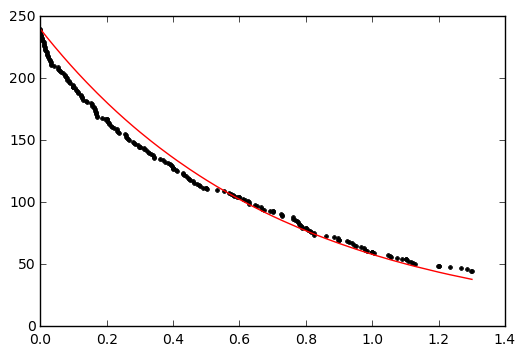

In [56]:
for i,obs in enumerate(observers):
    t,na = zip(*obs.data())
    plt.plot(t,na,'k.')
    plt.plot(t,[expfunc(params[i],N)(tt) for tt in t],'r-')
    #plt.xscale('log')
    print t[-25:]
#viz.plot_number_observer(*observers, *[expfunc(p, N) for p in params], ylim=(N * 0.2, N), legend=False)

In [9]:
kD = 4 * numpy.pi * (voxel_radius * 2) * (D * 2)
print kD
print 0.13662441*D

0.251327412287
0.13662441


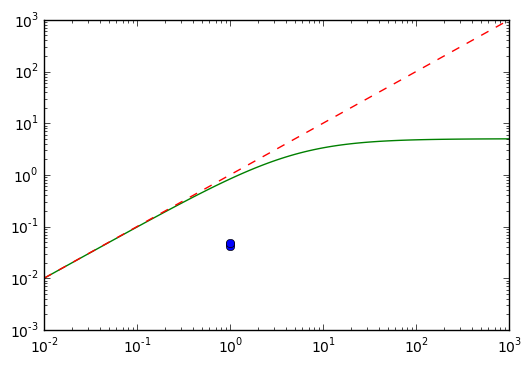

In [120]:
import matplotlib.pylab as plt
plot = plt.loglog
plot(ks, numpy.array(params) / (240 / 9.0), 'o')
x = numpy.logspace(-2, +3, 101)
plot(x, x / (1.0 + 0.2 * x), '-')
plot(x, x, '--')
plt.show()

In [11]:
v = 130. / (N / (L * L))
print(v, v / (D * 2))

(4.875, 2.4375)


In [12]:
2.4375 * 0.222 * 2

1.08225

In [13]:
1.08225 * 1000 / (30 * 30)

1.2025

In [14]:
k = (D + D) / (0.28986264423934294 * alpha)
print k

0.01


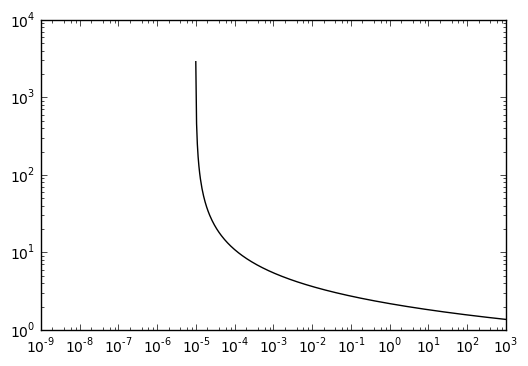

In [15]:
gamma = 0.5772156649
t = numpy.logspace(-9, +3, 601)
y = 4 * numpy.pi * (D + D) / (numpy.log(4 * (D + D) * t / (voxel_radius * voxel_radius)) - 2 * gamma)
import matplotlib.pylab as plt
plot = plt.loglog
plot(t, y, 'k-')
plt.show()

/home/chew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


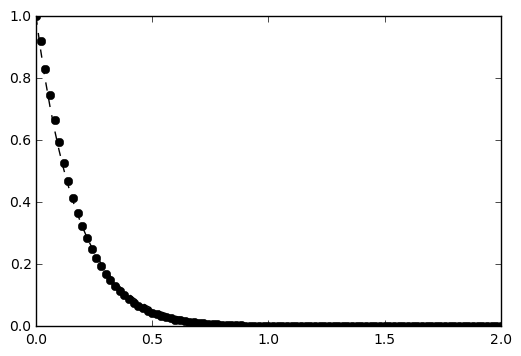

5.68519438742
151.605183665


In [16]:
import scipy
k = 1000
f = lambda x: k / (1 + k / 4 * numpy.pi * (D + D) / (numpy.log(4 * (D + D) * x / (voxel_radius * voxel_radius)) - 2 * gamma))
x = numpy.linspace(0, 2, 101)
y = [numpy.exp(-scipy.integrate.quad(f, 0, xi)[0]) for xi in x]
p, covar = curve_fit(lambda x, *args: expfunc(args[0], 1.0)(x), x, y, p0=[1.0])
plot = plt.plot
plot(x, y, 'ko')
plot(x, expfunc(p[0], 1.0)(x), 'k--')
plt.show()
print(p[0])
print(p[0] * N / (L * L))

In [17]:
def test(k):
    f = lambda x: k / (1 + k / 4 * numpy.pi * (D + D) / (numpy.log(4 * (D + D) * x / (voxel_radius * voxel_radius)) - 2 * gamma))
    x = numpy.linspace(0, 2, 101)
    y = [numpy.exp(-scipy.integrate.quad(f, 0, xi)[0]) for xi in x]
    p, covar = curve_fit(lambda x, *args: expfunc(args[0], 1.0)(x), x, y, p0=[1.0])
    return p[0]

/home/chew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/chew/.local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/chew/.local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and t

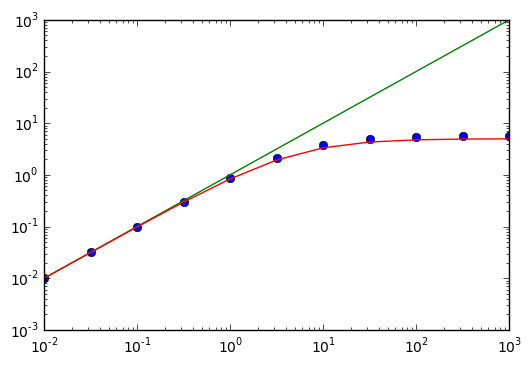

In [18]:
x = numpy.logspace(-2, +3, 11)
plt.loglog(x, [test(xi) for xi in x], 'o')
plt.loglog(x, x, '-')
plot(x, x / (1.0 + 0.2 * x), '-')
plt.show()